In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from sklearn.metrics import r2_score
from scipy.stats import norm
import scipy.stats as sts
import torch
from model import MLP
import json

plt.style.use(["grid", "science", "no-latex"])

with open("logs/training_loss.npy", "rb") as f:
    training_loss = np.load(f)
with open("logs/validation_loss.npy", "rb") as f:
    validation_loss = np.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("last_config") as f:
    config = json.load(f)

model = MLP(
    input_dim=config["input_dim"],
    output_dim=config["output_dim"],
    hidden_dim=config["hidden_dim"],
    depth=config["depth"],
    normalization=config["normalization"],
).to(device)
model.load_state_dict(torch.load("checkpoints/checkpoint.pth", map_location=device))
optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=config["base_lr"],
    max_lr=config["max_lr"],
    step_size_up=50,
    step_size_down=50
)
model.eval()

MLP(
  (input_layer): Linear(in_features=6, out_features=400, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=400, out_features=400, bias=True)
  )
  (output_layer): Linear(in_features=400, out_features=1, bias=True)
  (activation): SiLU()
  (normalization): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
)

In [2]:
learning_rate = []
for i in range(400):
    learning_rate.append(scheduler.get_last_lr())
    scheduler.step()

/users/eleves-a/2020/saad.souilmi/Cuda-Project/venv/lib64/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


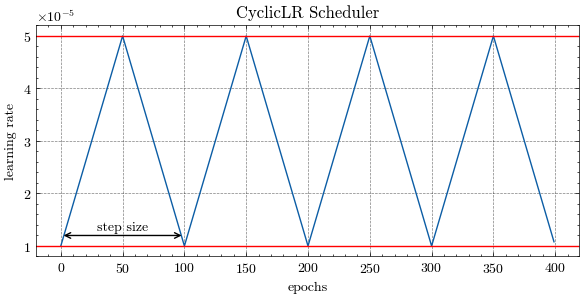

In [3]:
# Display scheduler
fig = plt.figure(figsize=(7, 3))

plt.plot(
    np.arange(400),
    learning_rate,
)
plt.axhline(y=0.00005, color="red")
plt.axhline(y=0.00001, color="red")
plt.annotate(
    text="", xy=(100, 0.000012), xytext=(0, 0.000012), arrowprops=dict(arrowstyle="<->")
)
plt.text(x=29, y=0.000013, s="step size")
plt.xlabel("epochs")
plt.ylabel("learning rate")
plt.title("CyclicLR Scheduler")
fig.savefig("img/CyclirLR-Scheduler.pdf")
plt.show()
plt.close()

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    gamma=0.95,
    step_size=20,
)
learning_rate = []
for i in range(800):
    learning_rate.append(scheduler.get_last_lr())
    scheduler.step()

/users/eleves-a/2020/saad.souilmi/Cuda-Project/venv/lib64/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


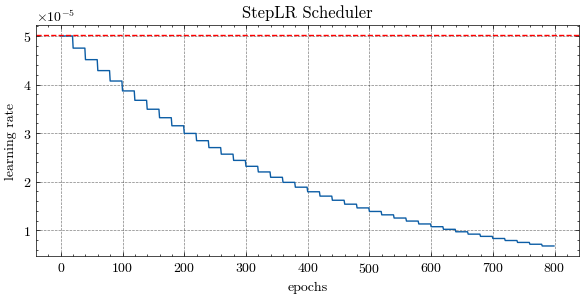

In [5]:
# Display scheduler
fig = plt.figure(figsize=(7, 3))

plt.plot(
    np.arange(800),
    learning_rate,
)
plt.axhline(y=0.0000501, color="red", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("learning rate")
plt.title("StepLR Scheduler")
fig.savefig("img/StepLR-Scheduler.pdf")
plt.show()
plt.close()

In [6]:
# summary statistics utilities
def residuals_diagnostic(
    y_true,
    y_pred,
    resid_density=norm.pdf,
    resid_density_name="Gaussian",
    density_range=None,
    save_fig=None
):
    residuals = y_true - y_pred
    r2 = r2_score(y_true, y_pred)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    ax1.scatter(y_pred, residuals, s=20, color="white", edgecolors="k")

    ax1.set_title("Residuals vs Fitted values")
    ax1.set_xlabel("fitted values")
    ax1.set_ylabel("residuals")

    ax2.hist(
        residuals,
        bins=100,
        edgecolor="k",
        density=True,
        color="white",
        label="Validation residuals",
    )
    if density_range is None:
        density_range = (-0.010, 0.007)
    mean = residuals.mean()
    std = residuals.std()
    if resid_density == sts.laplace.pdf:
        std = std / np.sqrt(2)
    ax2.plot(
        np.linspace(density_range[0], density_range[1], num=200),
        resid_density(
            np.linspace(density_range[0], density_range[1], num=200),
            loc=mean,
            scale=std,
        ),
        lw=1.5,
        linestyle="--",
        color="black",
        label=f"Fitted {resid_density_name}",
    )
    ax2.set_xlabel("residuals")
    ax2.set_ylabel("density")
    ax2.legend(loc=0)
    ax2.set_title("Residuals distribution")

    ax3.scatter(
        y_true,
        y_pred,
        s=20,
        edgecolor="k",
        color="white",
        label=rf"$R^2$={r2:.5f}",
    )
    ax3.legend(loc=0)
    ax3.set_title("Fitted values vs Target values")
    ax3.set_xlabel("target values")
    ax3.set_ylabel("fitted values")
    fig.tight_layout()
    if save_fig:
        fig.savefig(save_fig)
    plt.show()
    plt.close()

In [7]:
with open("data/X_valid.npy", "rb") as f:
    X_valid = np.load(f)
with open("data/Y_valid.npy", "rb") as f:
    Y_valid = np.load(f)

X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)

predictions = model(X_valid).flatten().detach().to("cpu").numpy()

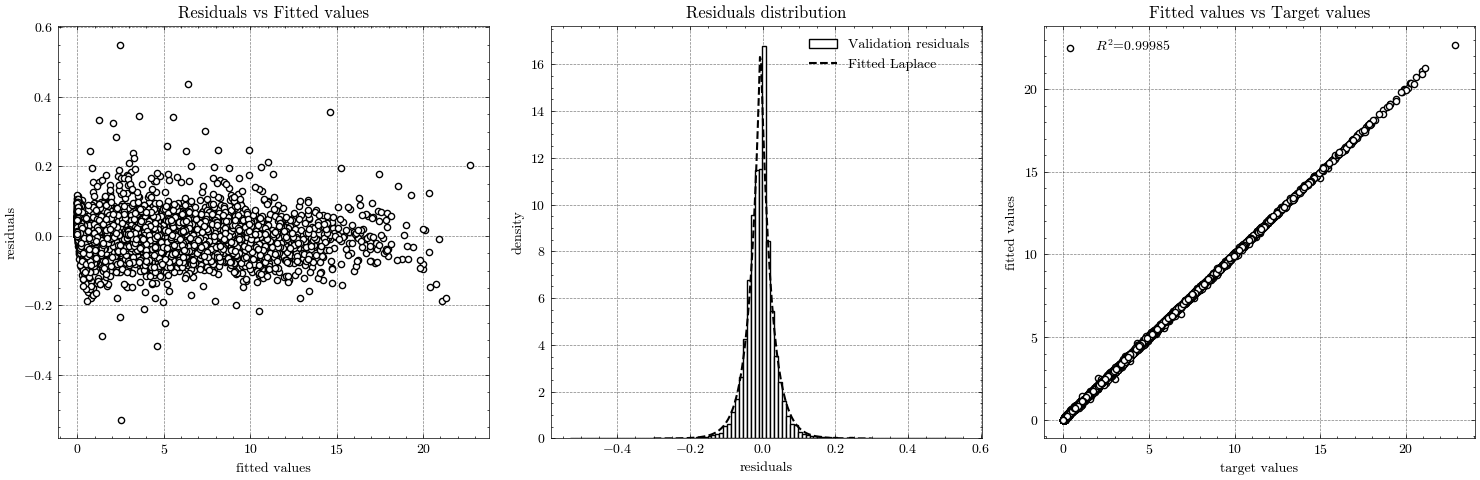

In [8]:
residuals_diagnostic(
    Y_valid,
    predictions,
    resid_density=sts.laplace.pdf,
    resid_density_name="Laplace",
    density_range=(-0.3, 0.3),
    save_fig="img/residuals_1kpaths_cyclirclr.pdf"
)

In [9]:
with open("logs/validation_loss_1k_paths_new.npy", "rb") as f:
    validation_loss_cyclicLR = np.load(f)
with open("logs/training_loss_1k_paths_new.npy", "rb") as f:
    training_loss_cyclicLR = np.load(f)

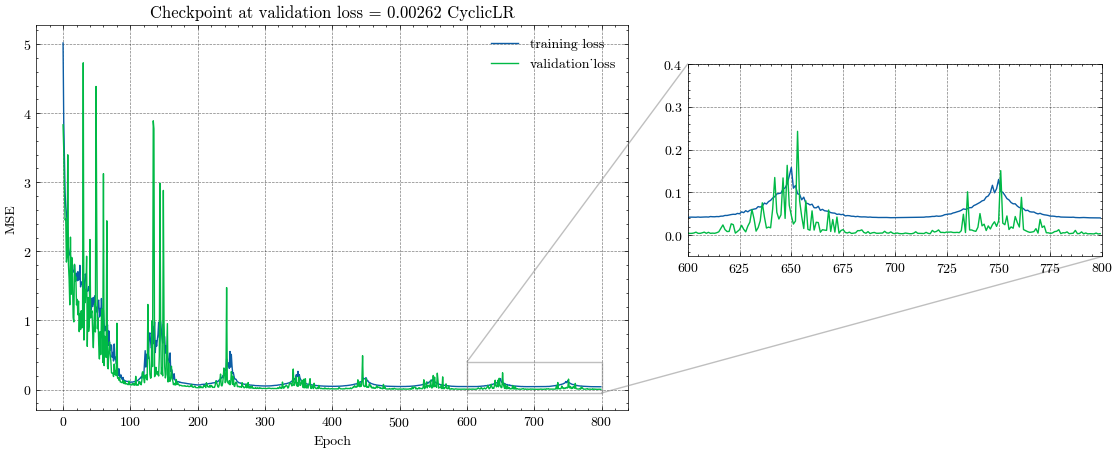

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(training_loss_cyclicLR[:], label="training loss")
ax.plot(validation_loss_cyclicLR[:], label="validation_loss")
# Zoomed portion
axins = ax.inset_axes([1.1, 0.4, 0.7, 0.5])
axins.plot(training_loss_cyclicLR[:], label="training loss")
axins.plot(validation_loss_cyclicLR[:], label="validation_loss")
x1, x2, y1, y2 = 600, 800, -0.05, 0.4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins)
ax.set_box_aspect(0.65)
# Ajust the subplot position
fig.subplots_adjust(left=0.01, right=2)

ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.set_title(f"Checkpoint at validation loss = {validation_loss_cyclicLR.min():.5f} CyclicLR")
legend = ax.legend(fancybox=True, edgecolor="k", loc=0)
legend.get_frame().set_linewidth(0.5)
fig.savefig("img/training_cycliclr_1kpaths.pdf")
plt.show()
plt.close()

In [11]:
with open("logs/validation_loss_1k_paths_steplr.npy", "rb") as f:
    validation_loss_stepLR = np.load(f)
with open("logs/training_loss_1k_paths_steplr.npy", "rb") as f:
    training_loss_stepLR = np.load(f)

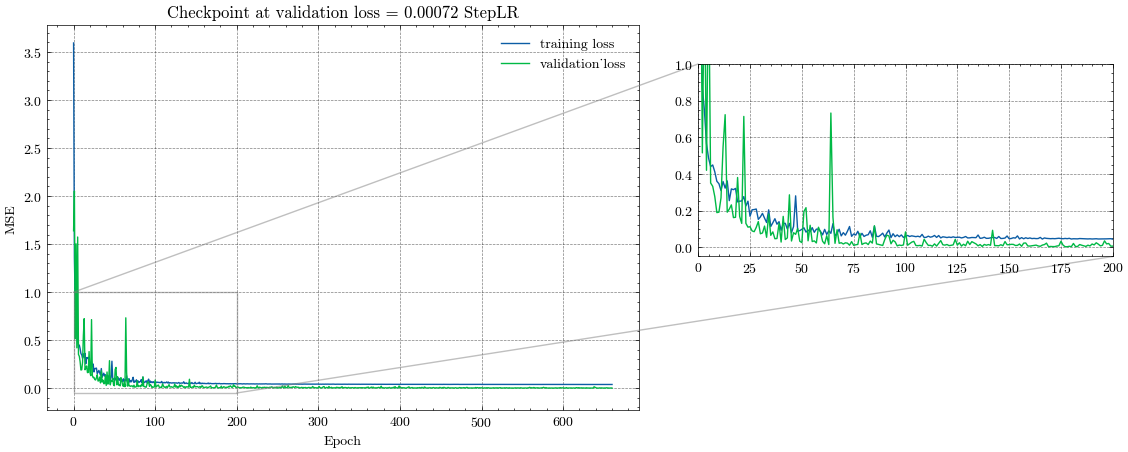

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(training_loss_stepLR[:], label="training loss")
ax.plot(validation_loss_stepLR[:], label="validation_loss")
# Zoomed portion
axins = ax.inset_axes([1.1, 0.4, 0.7, 0.5])
axins.plot(training_loss_stepLR[:], label="training loss")
axins.plot(validation_loss_stepLR[:], label="validation_loss")
x1, x2, y1, y2 = 0, 200, -0.05, 1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins)
ax.set_box_aspect(0.65)
# Ajust the subplot position
fig.subplots_adjust(left=0.01, right=2)

ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.set_title(f"Checkpoint at validation loss = {validation_loss_stepLR.min():.5f} StepLR")
legend = ax.legend(fancybox=True, edgecolor="k", loc=0)
legend.get_frame().set_linewidth(0.5)
fig.savefig("img/training_steplr_1kpaths.pdf")
plt.show()
plt.close()

In [13]:
model.load_state_dict(torch.load("checkpoints/checkpoint_1k_paths_steplr.pth", map_location=device))

<All keys matched successfully>

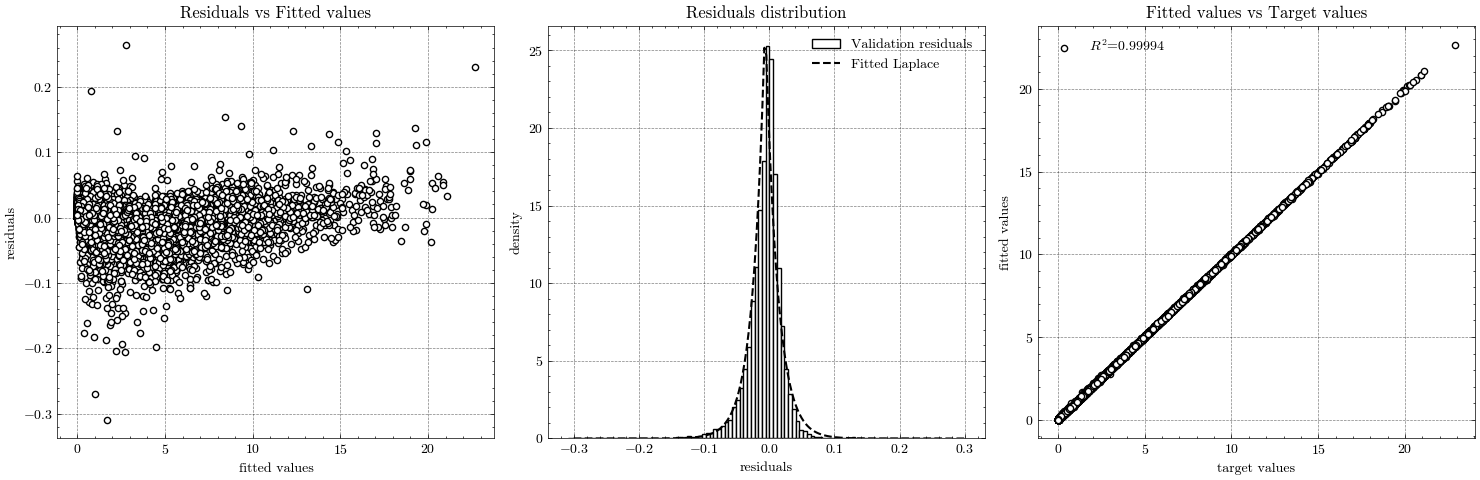

In [14]:
predictions = model(X_valid).flatten().detach().to("cpu").numpy()
residuals_diagnostic(
    Y_valid,
    predictions,
    resid_density=sts.laplace.pdf,
    resid_density_name="Laplace",
    density_range=(-0.3, 0.3),
    save_fig="img/residuals_1kpaths_steplr.pdf"
)